[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rsarka34/MHSONN/blob/main/model/MHSONN.ipynb)

**A Novel Multi-Head Self-Organized Operational Neural Network Architecture for Chronic Obstructive Pulmonary Disease Detection Using Lung Sounds**

**Coder: Arka Roy**

**Github Profile:** **[https://github.com/rsarka34](https://github.com/rsarka34)**

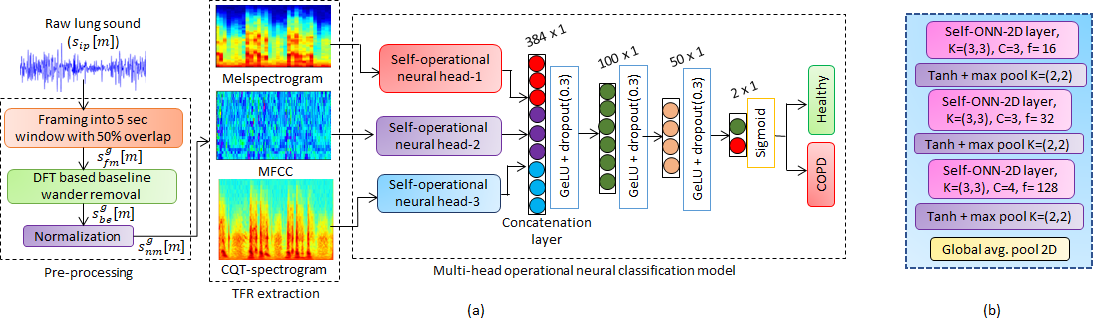

# **Creating data for COPD-MHSONN**

In [ ]:
import cv2 as cvlib
import librosa
import scipy.io as sio
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from google.colab import drive
drive.mount('/content/gdrive')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!git clone https://github.com/junaidmalik09/fastonn.git
%cd /content/fastonn
!pip install .
import fastonn
from fastonn import SelfONN2d

fatal: destination path 'fastonn' already exists and is not an empty directory.
/content/fastonn
Processing /content/fastonn
  Preparing metadata (setup.py) ... done
  Created wheel for fastonn: filename=fastonn-0.1.1-py3-none-any.whl size=299577 sha256=3de61b526c63f11398df2fd41552ead0ffdc3ceecabaee4bc15c9fc715f3e344
  Stored in directory: /tmp/pip-ephem-wheel-cache-_7ffdxkc/wheels/61/8b/99/d8de1ae4507a27413aa8596d19e503645ccfdb3df60b239682
Successfully built fastonn
  Attempting uninstall: fastonn
    Found existing installation: fastonn 0.1.1
    Uninstalling fastonn-0.1.1:
      Successfully uninstalled fastonn-0.1.1


In [ ]:
# !pip install mat73
# import mat73
# sig_dict = mat73.loadmat('/content/gdrive/MyDrive/ARKA/7class_disease_work/7class_sig.mat')
# sig=sig_dict['all_sig']

# copd_sig=sig[:,4525:11166];healthy_sig=sig[:,11167:15306];
# all_sigs=np.concatenate((copd_sig,healthy_sig), axis=1)
# print(all_sigs.shape)

(20000, 10780)


In [ ]:
# from scipy.io import savemat
# mdic = {"copd_normal_labels": all_labels}
# savemat("/content/gdrive/MyDrive/ARKA/copd_normal_labels.mat", mdic)

In [ ]:
r=len(all_sigs[1,:])
nfft=1024
win_length=1024
hop_length=410;sr=4000
melspec_list=[];mfcc_list=[]; cqt_list=[];
d_shape=64

import cv2 as cvlib
for i in range (r):
  clip=all_sigs[:,i]
  # melspectrogram
  mel_spec=librosa.feature.melspectrogram(y=clip,sr=4000,n_mels=64,n_fft=1024,hop_length=524,win_length=1024,window='hann')
  log_melspec = librosa.amplitude_to_db(mel_spec)
  norm_melspec=(log_melspec-np.min(log_melspec))/(np.max(log_melspec)-np.min(log_melspec))
  mel_img=np.flip(norm_melspec, 0)
  melspec_list.append(mel_img)
  # mfcc extraction
  mfccs = librosa.feature.mfcc(y=clip, sr=4000, n_mfcc=30)
  mfcc_img=np.flip(mfccs, 0)
  mfcc_list.append(mfccs)
  # CQT extraction
  cqts= np.abs(librosa.cqt(y=clip, sr=4000, hop_length=512, n_bins=64, window='hann', pad_mode='reflect'))
  log_cqt=librosa.amplitude_to_db(cqts)
  norm_cqt=(log_cqt-np.min(log_cqt))/(np.max(log_cqt)-np.min(log_cqt))
  cqt_img=np.flip(norm_cqt, 0)
  cqt_list.append(cqt_img)

melspec_set=np.array(melspec_list)
mfcc_set=np.array(mfcc_list)
cqt_set=np.array(cqt_list)
print('shape of melspectrogram dataset'+str(np.shape(melspec_set)))
print('shape of mfcc dataset'+str(np.shape(mfcc_set)))
print('shape of cqt dataset'+str(np.shape(cqt_set)))

shape of melspectrogram dataset(10780, 64, 39)
shape of mfcc dataset(10780, 30, 40)
shape of cqt dataset(10780, 64, 40)


In [ ]:
import pickle
def pickle_save(location_to_save,dumping_var):
    outfile = open(location_to_save,'wb')
    pickle.dump(dumping_var,outfile)
    outfile.close()
    print('=========done=========')

base_location='/content/gdrive/MyDrive/ARKA/COPD_MSONN/'
saving_melspec=base_location+'Melspecs_copd_healthy'
saving_mfcc=base_location+'Mfccs_copd_healthy'
saving_cqt=base_location+'CQTs_copd_healthy'

pickle_save(saving_melspec,melspec_set)
pickle_save(saving_mfcc,mfcc_set)
pickle_save(saving_cqt,cqt_set)

In [ ]:
import pickle
def load_pickle_file(name_of_file):
    infile = open(name_of_file,'rb')
    wgt = pickle.load(infile)
    infile.close()
    print('=========loading done=========')
    return wgt

Melspecs= load_pickle_file('/content/gdrive/MyDrive/ARKA/COPD_MSONN/Melspecs_copd_healthy')
Melspecs_re=np.reshape(Melspecs,(Melspecs.shape[0],1,Melspecs.shape[1],Melspecs.shape[2]))
Mfccs= load_pickle_file('/content/gdrive/MyDrive/ARKA/COPD_MSONN/Mfccs_copd_healthy')
Mfccs_re=np.reshape(Mfccs,(Mfccs.shape[0],1,Mfccs.shape[1],Mfccs.shape[2]))
CQTs= load_pickle_file('/content/gdrive/MyDrive/ARKA/COPD_MSONN/CQTs_copd_healthy')
CQTs_re=np.reshape(CQTs,(CQTs.shape[0],1,CQTs.shape[1],CQTs.shape[2]))

=========loading done=========
=========loading done=========
=========loading done=========


In [ ]:
print('shape of melspectrogram dataset'+str(np.shape(Melspecs_re)))
print('shape of mfcc dataset'+str(np.shape(Mfccs_re)))
print('shape of cqt dataset'+str(np.shape(CQTs_re)))

shape of melspectrogram dataset(10780, 1, 64, 39)
shape of mfcc dataset(10780, 1, 30, 40)
shape of cqt dataset(10780, 1, 64, 40)


In [ ]:
labels=pd.read_excel('/content/gdrive/MyDrive/ARKA/7class_disease_work/7class_labels.xlsx',header=None)
l=np.array(labels);copd_labels=l[4525:11166];healthy_labels=l[11167:15306];
all_labels=np.concatenate((copd_labels,healthy_labels), axis=0)
label_list=[]
for i in range (10780):
  if all_labels[i]=='COPD':
    label_list.append(0)
  elif all_labels[i]=='Healthy':
    label_list.append(1)
Y=np.array(label_list)
Y.shape

(10780,)

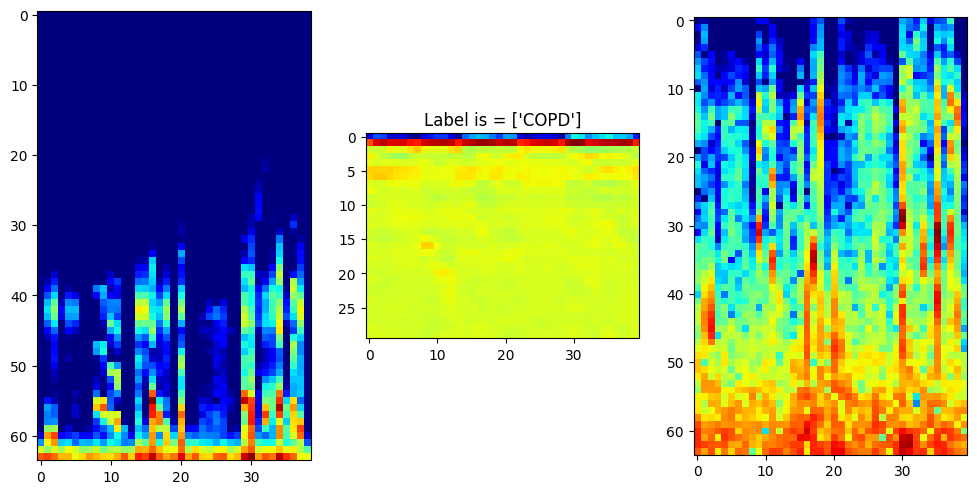

In [ ]:
idx=5;
plt.figure(figsize=(12,8))
plt.subplot(131); plt.imshow(Melspecs[idx,:,:], cmap="jet");
plt.subplot(132); plt.imshow(Mfccs[idx,:,:], cmap="jet"); plt.title('Label is = '+str(all_labels[idx]))
plt.subplot(133); plt.imshow(CQTs[idx,:,:], cmap="jet");

In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

143

# **Tripple Scale SONN Based Analysis**

***Data loading helper functions***

In [ ]:
from sklearn.model_selection import train_test_split
def create_datasets(Xmel,Xmfcc,Xcqt, y, test_size=0.15,seed=None):
    Xmel_train1, Xmel_test, Xmfcc_train1,Xmfcc_test,Xcqt_train1,Xcqt_test, y_train1, y_test = train_test_split(Xmel,Xmfcc,Xcqt, Y, test_size=0.1,random_state=seed)
    print(y_test.shape)
    Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid, y_train, y_valid = train_test_split(Xmel_train1,Xmfcc_train1,Xcqt_train1, y_train1, test_size=0.1,random_state=seed)
    Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid,Xmel_test,Xmfcc_test,Xcqt_test = [torch.tensor(arr, dtype=torch.float32) for arr in (Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid,Xmel_test,Xmfcc_test,Xcqt_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(Xmel_train,Xmfcc_train,Xcqt_train, y_train)
    valid_ds = TensorDataset(Xmel_valid,Xmfcc_valid,Xcqt_valid, y_valid)
    test_ds= TensorDataset(Xmel_test,Xmfcc_test,Xcqt_test, y_test)
    return train_ds, valid_ds, test_ds

def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=2):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl

bs = 128
print('Preparing datasets')
trn_ds, val_ds, tst_ds = create_datasets(Melspecs_re,Mfccs_re,CQTs_re,Y,seed=10)
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)

Preparing datasets
(1078,)
Creating data loaders with batch size: 128


## **Train Triple scale Self-organized Operartional Neural Network**

In [ ]:
from torch import nn
from torchsummary import summary
out_filter=128
class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1,out_channels=16,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16,out_channels=32,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32,out_channels=out_filter,kernel_size=3,q=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.GAP=nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(3*out_filter, 100)
        self.linear2 = nn.Linear(100, 50)
        self.gelu=nn.GELU()
        self.relu=nn.ReLU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(50, 2)


    def forward(self, melspec_data, mfcc_data, cqt_data):
        # melspectrogram scale
        x_mel = self.onnv1(melspec_data)
        x_mel = self.onnv2(x_mel)
        x_mel = self.onnv3(x_mel)
        x_mel_flat=self.GAP(x_mel)
        # mfcc scale
        x_mfcc = self.onnv1(mfcc_data)
        x_mfcc = self.onnv2(x_mfcc)
        x_mfcc = self.onnv3(x_mfcc)
        x_mfcc_flat=self.GAP(x_mfcc)
        # cqt scale
        x_cqt = self.onnv1(cqt_data)
        x_cqt = self.onnv2(x_cqt)
        x_cqt = self.onnv3(x_cqt)
        x_cqt_flat=self.GAP(x_cqt)

        x_concat = torch.cat((x_mel_flat, x_mfcc_flat,x_cqt_flat), dim=1)
        x=self.flatten(x_concat)
        x = self.dropout(x)
        x=self.relu(x)
        x = self.linear1(x)
        x=self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x=self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)
summary(model, [(1, 64, 39),(1, 30,40),(1, 64, 40)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         SelfONN2d-1           [-1, 16, 62, 37]             448
              Tanh-2           [-1, 16, 62, 37]               0
         MaxPool2d-3           [-1, 16, 31, 18]               0
         SelfONN2d-4           [-1, 32, 29, 16]          13,856
              Tanh-5           [-1, 32, 29, 16]               0
         MaxPool2d-6            [-1, 32, 14, 8]               0
         SelfONN2d-7           [-1, 128, 12, 6]         147,584
              Tanh-8           [-1, 128, 12, 6]               0
         MaxPool2d-9            [-1, 128, 6, 3]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
        SelfONN2d-11           [-1, 16, 28, 38]             448
             Tanh-12           [-1, 16, 28, 38]               0
        MaxPool2d-13           [-1, 16, 14, 19]               0
        SelfONN2d-14           [-1, 32,

**Triple scale Self-organized Operartional Neural Network**

In [ ]:
from torch import nn
from torchsummary import summary
out_filter=128
class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1,out_channels=16,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16,out_channels=32,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32,out_channels=out_filter,kernel_size=3,q=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.GAP=nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(3*out_filter, 100)
        self.linear2 = nn.Linear(100, 50)
        self.gelu=nn.GELU()
        self.relu=nn.ReLU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(50, 2)


    def forward(self, melspec_data, mfcc_data, cqt_data):
        # melspectrogram scale
        x_mel = self.onnv1(melspec_data)
        x_mel = self.onnv2(x_mel)
        x_mel = self.onnv3(x_mel)
        x_mel_flat=self.GAP(x_mel)
        # mfcc scale
        x_mfcc = self.onnv1(mfcc_data)
        x_mfcc = self.onnv2(x_mfcc)
        x_mfcc = self.onnv3(x_mfcc)
        x_mfcc_flat=self.GAP(x_mfcc)
        # cqt scale
        x_cqt = self.onnv1(cqt_data)
        x_cqt = self.onnv2(x_cqt)
        x_cqt = self.onnv3(x_cqt)
        x_cqt_flat=self.GAP(x_cqt)

        x_concat = torch.cat((x_mel_flat, x_mfcc_flat,x_cqt_flat), dim=1)
        x=self.flatten(x_concat)
        x = self.dropout(x)
        x=self.relu(x)
        x = self.linear1(x)
        x=self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x=self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)
summary(model, [(1, 64, 39),(1, 30,40),(1, 64, 40)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         SelfONN2d-1           [-1, 16, 62, 37]             448
              Tanh-2           [-1, 16, 62, 37]               0
         MaxPool2d-3           [-1, 16, 31, 18]               0
         SelfONN2d-4           [-1, 32, 29, 16]          13,856
              Tanh-5           [-1, 32, 29, 16]               0
         MaxPool2d-6            [-1, 32, 14, 8]               0
         SelfONN2d-7           [-1, 128, 12, 6]         147,584
              Tanh-8           [-1, 128, 12, 6]               0
         MaxPool2d-9            [-1, 128, 6, 3]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
        SelfONN2d-11           [-1, 16, 28, 38]             448
             Tanh-12           [-1, 16, 28, 38]               0
        MaxPool2d-13           [-1, 16, 14, 19]               0
        SelfONN2d-14           [-1, 32,

In [ ]:
lr = 0.001
n_epochs = 150
iterations_per_epoch = len(trn_dl)

trainloss_history = []
valacc_history = []
valloss_history = []
trainacc_history=[]
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)


print('Start model training')

for epoch in range(1, n_epochs + 1):
    correct, total = 0, 0
    for i, (xmel_batch,xmfcc_batch,xcqt_batch, y_batch) in enumerate(trn_dl):
        model.train()
        xmel_batch,xmfcc_batch,xcqt_batch = xmel_batch.cuda(),xmfcc_batch.cuda(),xcqt_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        out_tr = model(xmel_batch,xmfcc_batch,xcqt_batch)
        loss =  criterion(out_tr, y_batch)
        preds_tr = F.log_softmax(out_tr, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds_tr == y_batch).sum().item()
        loss.backward()
        opt.step()
    trainloss_history.append(loss)
    train_acc = correct / total
    trainacc_history.append(train_acc)
    with torch.no_grad():
        model.eval()
        correct, total = 0, 0
        for xmel_val,xmfcc_val,xcqt_val, y_val in (val_dl):
            xmel_val,xmfcc_val,xcqt_val=xmel_val.cuda(),xmfcc_val.cuda(),xcqt_val.cuda()
            y_val = y_val.cuda()
            out_vl = model(xmel_val,xmfcc_val,xcqt_val)
            valid_loss = criterion(out_vl, y_val)
            preds = F.log_softmax(out_vl, dim=1).argmax(dim=1)
            total += y_val.size(0)
            correct += (preds == y_val).sum().item()
    valloss_history.append(valid_loss)
    valid_acc = correct / total
    valacc_history.append(valid_acc)
    print(f'Epoch: {epoch:3d}. Training Loss: {loss:.4f}. Validation Loss: {valid_loss:.4f}. Training Acc.: {train_acc:2.2%}  Validation Acc.: {valid_acc:2.2%}')

Start model training
Epoch:   1. Training Loss: 0.5101. Validation Loss: 0.5530. Training Acc.: 67.67%  Validation Acc.: 76.62%
Epoch:   2. Training Loss: 0.5398. Validation Loss: 0.4604. Training Acc.: 75.81%  Validation Acc.: 79.71%
Epoch:   3. Training Loss: 0.4621. Validation Loss: 0.4547. Training Acc.: 77.38%  Validation Acc.: 80.54%
Epoch:   4. Training Loss: 0.3035. Validation Loss: 0.3806. Training Acc.: 79.80%  Validation Acc.: 85.27%
Epoch:   5. Training Loss: 0.2496. Validation Loss: 0.2837. Training Acc.: 82.66%  Validation Acc.: 87.02%
Epoch:   6. Training Loss: 0.3536. Validation Loss: 0.3400. Training Acc.: 84.40%  Validation Acc.: 85.17%
Epoch:   7. Training Loss: 0.4060. Validation Loss: 0.2499. Training Acc.: 85.83%  Validation Acc.: 90.42%
Epoch:   8. Training Loss: 0.5783. Validation Loss: 0.2721. Training Acc.: 86.28%  Validation Acc.: 89.08%
Epoch:   9. Training Loss: 0.3145. Validation Loss: 0.2130. Training Acc.: 87.86%  Validation Acc.: 91.04%
Epoch:  10. Trai

(0.0, 1.0)

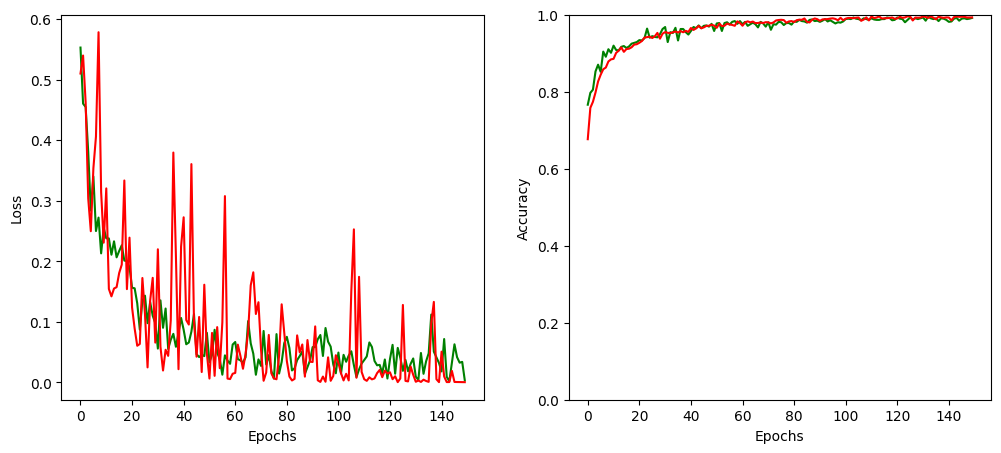

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(val_loss_np,'g');plt.plot(train_loss_np,'r');
plt.ylabel('Loss');plt.xlabel('Epochs')
plt.subplot(122)
plt.plot(val_acc_np,'g');plt.plot(train_acc_np,'r');
plt.ylabel('Accuracy');plt.xlabel('Epochs')
plt.ylim(0,1)

## **Testing of the model**

In [ ]:
from torch import nn
from torchsummary import summary
out_filter=128
class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1,out_channels=16,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16,out_channels=32,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32,out_channels=out_filter,kernel_size=3,q=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.GAP=nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(3*out_filter, 100)
        self.linear2 = nn.Linear(100, 50)
        self.gelu=nn.GELU()
        self.relu=nn.ReLU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(50, 2)


    def forward(self, melspec_data, mfcc_data, cqt_data):
        # melspectrogram scale
        x_mel = self.onnv1(melspec_data)
        x_mel = self.onnv2(x_mel)
        x_mel = self.onnv3(x_mel)
        x_mel_flat=self.GAP(x_mel)
        # mfcc scale
        x_mfcc = self.onnv1(mfcc_data)
        x_mfcc = self.onnv2(x_mfcc)
        x_mfcc = self.onnv3(x_mfcc)
        x_mfcc_flat=self.GAP(x_mfcc)
        # cqt scale
        x_cqt = self.onnv1(cqt_data)
        x_cqt = self.onnv2(x_cqt)
        x_cqt = self.onnv3(x_cqt)
        x_cqt_flat=self.GAP(x_cqt)

        x_concat = torch.cat((x_mel_flat, x_mfcc_flat,x_cqt_flat), dim=1)
        x=self.flatten(x_concat)
        x = self.dropout(x)
        x=self.relu(x)
        x = self.linear1(x)
        x=self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x=self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)

PATH= "/content/gdrive/MyDrive/ARKA/COPD_MSONN/Results/COPD_MSONN_trained_on_2023_04_13_17_10_17.pt"
model=torch.load(PATH)

Preparing datasets
(1078,)
Test accuracy is = 99.81447124304268%


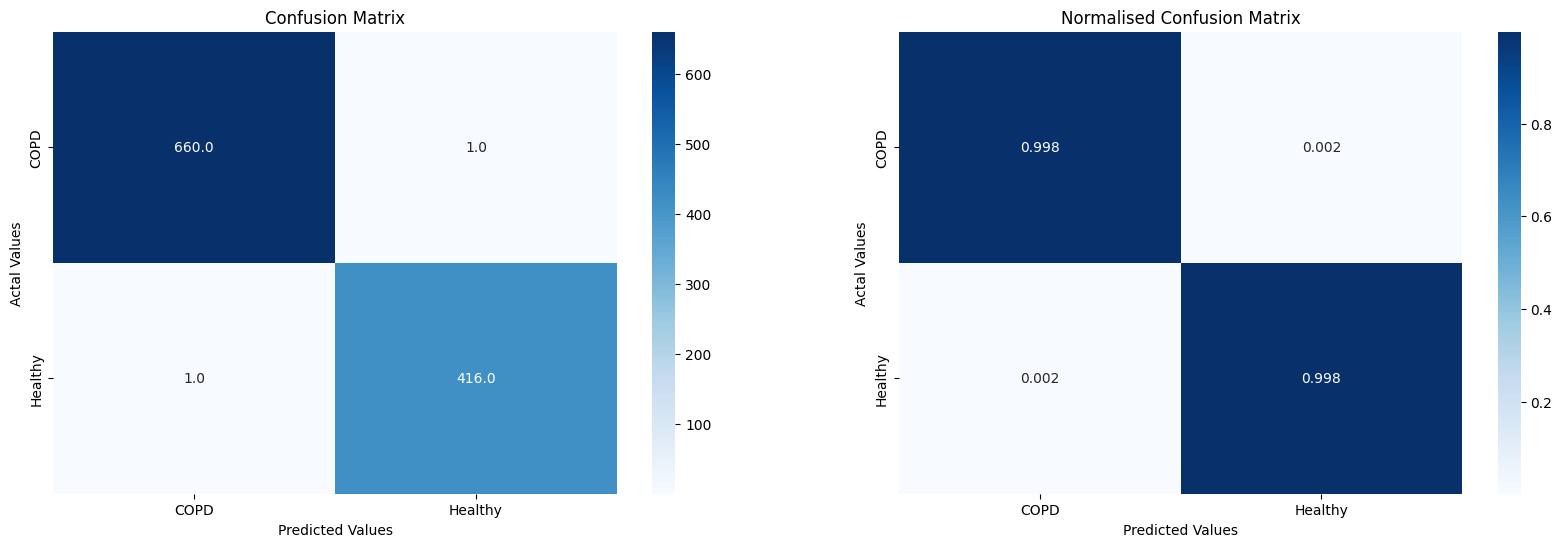

Accuracy =99.81447124304268
Sen =99.84871406959152
spc =99.76019184652279
prc =99.84871406959152
F1 =99.84871406959152


In [ ]:
from sklearn.model_selection import train_test_split
def create_datasets(Xmel,Xmfcc,Xcqt, y, test_size=0.15,seed=None):
    Xmel_train1, Xmel_test, Xmfcc_train1,Xmfcc_test,Xcqt_train1,Xcqt_test, y_train1, y_test = train_test_split(Xmel,Xmfcc,Xcqt, Y, test_size=0.1,random_state=seed)
    print(y_test.shape)
    Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid, y_train, y_valid = train_test_split(Xmel_train1,Xmfcc_train1,Xcqt_train1, y_train1, test_size=0.1,random_state=seed)
    Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid,Xmel_test,Xmfcc_test,Xcqt_test = [torch.tensor(arr, dtype=torch.float32) for arr in (Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid,Xmel_test,Xmfcc_test,Xcqt_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(Xmel_train,Xmfcc_train,Xcqt_train, y_train)
    valid_ds = TensorDataset(Xmel_valid,Xmfcc_valid,Xcqt_valid, y_valid)
    test_ds= TensorDataset(Xmel_test,Xmfcc_test,Xcqt_test, y_test)
    return train_ds, valid_ds, test_ds
def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=2):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl

bs = 128
print('Preparing datasets')
trn_ds, val_ds, tst_ds = create_datasets(Melspecs_re,Mfccs_re,CQTs_re,Y,seed=18)#32,39,1,18,17
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.linear2.register_forward_hook(get_activation('linear2'))


FEATS = []
y_true = [];y_pred=[]
# placeholder for batch features
features = {}
for xmel_tst,xmfcc_tst,xcqt_tst,y_tst in tst_dl:
    xmel_tst,xmfcc_tst,xcqt_tst = xmel_tst.cuda(),xmfcc_tst.cuda(),xcqt_tst.cuda()
    out = model(xmel_tst,xmfcc_tst,xcqt_tst)
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    y_hat=y_hat.data.cpu().numpy()
    y_pred.extend(y_hat) # Save preds
    fea=activation['linear2'].data.cpu().numpy()
    #print('feature tensor shape:',fea.shape)
    FEATS.append(fea)
    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth

FEATS = np.concatenate(FEATS)
y_true=np.array(y_true)

from sklearn.metrics import confusion_matrix
import seaborn as sns;
cm=confusion_matrix(y_true,y_pred)
Acc=cm.trace()/np.sum(cm)
print('Test accuracy is = '+str(Acc*100)+'%')
cm_norm=confusion_matrix(y_true,y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['COPD','Healthy'],
                     columns = ['COPD','Healthy'])
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues",fmt = ".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['COPD','Healthy'],
                     columns = ['COPD','Healthy'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues",fmt = ".3f")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

acc=cm.trace()/np.sum(cm);
sen=(cm[0,0])/(cm[0,0]+cm[0,1]);
spc=(cm[1,1])/(cm[1,0]+cm[1,1]);
prc=(cm[0,0])/(cm[0,0]+cm[1,0]);
f1_score=(2*prc*sen)/(prc+sen);
print('Accuracy ='+str(acc*100))
print('Sen ='+str(sen*100))
print('spc ='+str(spc*100))
print('prc ='+str(prc*100))
print('F1 ='+str(f1_score*100))

## **TSNE Embedding plot**

[Text(0.5, 1.0, 'T-SNE projection for test case')]

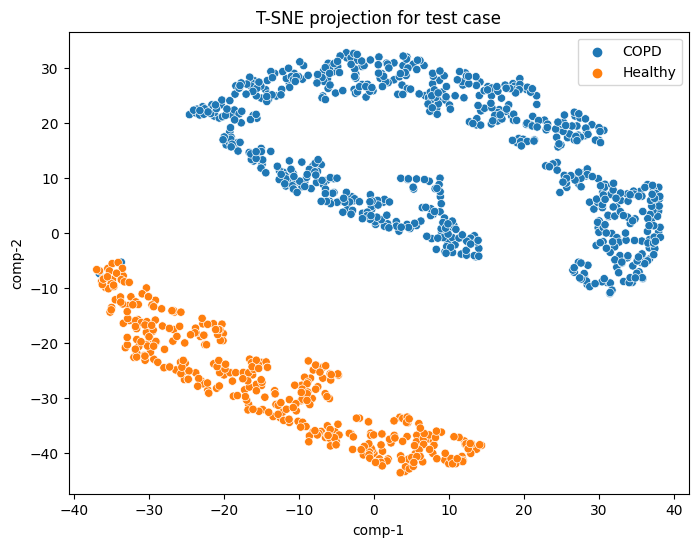

In [ ]:
q=y_true
label_l=[]
for i in range (q.shape[0]):
  if q[i]==0:
    label_l.append('COPD')
  elif q[i]==1:
    label_l.append('Healthy')

Label_ar=np.array(label_l)

import seaborn as sns;
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,learning_rate='auto',init='random')
def scatter(x, labels):
    # We create a scatter plot.
    plt.figure(figsize=(10,8))
    sns.scatterplot(x[:,0], x[:,1], hue=labels,palette="deep")
    plt.xlabel("Dimension 1",fontweight ='bold', fontsize = 15);plt.ylabel("Dimenssion 2",fontweight ='bold', fontsize = 15)
Y_embedded = tsne.fit_transform(FEATS)

df = pd.DataFrame()
df["Labels"] = Label_ar
df["comp-1"] = Y_embedded[:,0]
df["comp-2"] = Y_embedded[:,1]
import seaborn as sns
plt.figure(figsize=(8,6))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.Labels.tolist(),
                data=df).set(title="T-SNE projection for test case")

## **TSNE of raw mel spectrogram**

In [ ]:
bs = 1078
print('Preparing datasets')
trn_ds, val_ds, tst_ds = create_datasets(Melspecs_re,Mfccs_re,CQTs_re,Y,seed=10)
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)
for xmel_tst,xmfcc_tst,xcqt_tst,y_tst in tst_dl:
    xmel_tst,xmfcc_tst,xcqt_tst = xmel_tst.cuda(),xmfcc_tst.cuda(),xcqt_tst.cuda()

xmel_tst_arr=xmel_tst.data.cpu().numpy()
xmel_tst_re=np.reshape(xmel_tst_arr,(xmel_tst.shape[0],xmel_tst.shape[2]*xmel_tst.shape[3]))
rawtest_tsne_embeds = tsne.fit_transform(xmel_tst_re)
df_raw = pd.DataFrame()
df_raw ["Labels"] = Label_ar
df_raw ["comp-1"] = rawtest_tsne_embeds[:,0]
df_raw ["comp-2"] = rawtest_tsne_embeds[:,1]

Preparing datasets
(1078,)
Creating data loaders with batch size: 1078


[Text(0.5, 1.0, 'T-SNE projection for raw signals')]

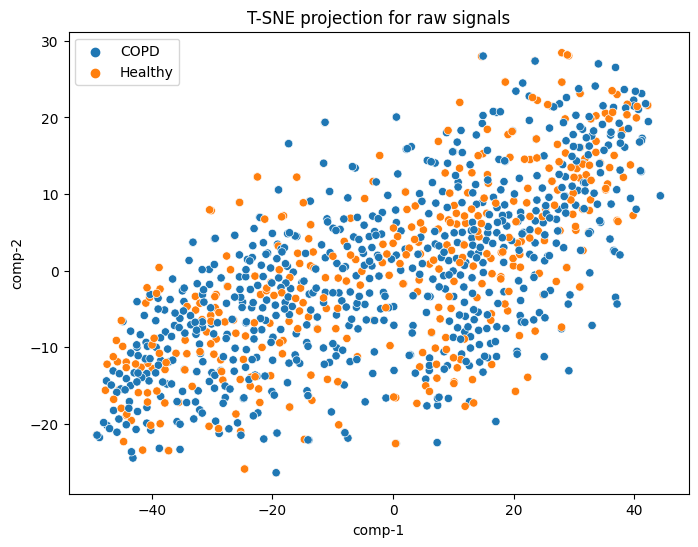

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.scatterplot(x="comp-1", y="comp-2", hue=df_raw.Labels.tolist(),
                data=df_raw).set(title="T-SNE projection for raw signals")

# **BL1: Dual Stream SONN Based Analysis (Melspectrogram and CQT)**

***Data loading helper functions***

In [ ]:
from sklearn.model_selection import train_test_split
def create_datasets(Xmel,Xcqt, y, test_size=0.1,seed=None):
    Xmel_train1, Xmel_test, Xcqt_train1, Xcqt_test, y_train1, y_test = train_test_split(Xmel, Xcqt, Y, test_size=0.1, random_state=seed)
    print(y_test.shape)
    Xmel_train, Xmel_valid, Xcqt_train, Xcqt_valid, y_train, y_valid = train_test_split(Xmel_train1, Xcqt_train1, y_train1, test_size=0.1,random_state=seed)
    Xmel_train, Xmel_valid, Xcqt_train, Xcqt_valid, Xmel_test, Xcqt_test = [torch.tensor(arr, dtype=torch.float32) for arr in (Xmel_train, Xmel_valid, Xcqt_train, Xcqt_valid, Xmel_test, Xcqt_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(Xmel_train,Xcqt_train, y_train)
    valid_ds = TensorDataset(Xmel_valid,Xcqt_valid, y_valid)
    test_ds= TensorDataset(Xmel_test,Xcqt_test, y_test)
    return train_ds, valid_ds, test_ds

def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=2):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl

bs = 128
print('Preparing datasets')
trn_ds, val_ds, tst_ds = create_datasets(Melspecs_re,CQTs_re,Y,seed=10)
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)

Preparing datasets
(1078,)
Creating data loaders with batch size: 128


In [ ]:
from torch import nn
from torchsummary import summary
out_filter=128
class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1,out_channels=16,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16,out_channels=32,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32,out_channels=out_filter,kernel_size=3,q=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.GAP=nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(2*out_filter, 100)
        self.gelu=nn.GELU()
        self.relu=nn.ReLU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(100, 2)


    def forward(self, melspec_data, cqt_data):
        # melspectrogram scale
        x_mel = self.onnv1(melspec_data)
        x_mel = self.onnv2(x_mel)
        x_mel = self.onnv3(x_mel)
        x_mel_flat=self.GAP(x_mel)

        # cqt scale
        x_cqt = self.onnv1(cqt_data)
        x_cqt = self.onnv2(x_cqt)
        x_cqt = self.onnv3(x_cqt)
        x_cqt_flat=self.GAP(x_cqt)

        x_concat = torch.cat((x_mel_flat, x_cqt_flat), dim=1)
        x=self.flatten(x_concat)
        x = self.dropout(x)
        x=self.relu(x)
        x = self.linear1(x)
        x=self.gelu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)
summary(model, [(1, 64, 39),(1, 64, 40)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         SelfONN2d-1           [-1, 16, 62, 37]             448
              Tanh-2           [-1, 16, 62, 37]               0
         MaxPool2d-3           [-1, 16, 31, 18]               0
         SelfONN2d-4           [-1, 32, 29, 16]          13,856
              Tanh-5           [-1, 32, 29, 16]               0
         MaxPool2d-6            [-1, 32, 14, 8]               0
         SelfONN2d-7           [-1, 128, 12, 6]         147,584
              Tanh-8           [-1, 128, 12, 6]               0
         MaxPool2d-9            [-1, 128, 6, 3]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
        SelfONN2d-11           [-1, 16, 62, 38]             448
             Tanh-12           [-1, 16, 62, 38]               0
        MaxPool2d-13           [-1, 16, 31, 19]               0
        SelfONN2d-14           [-1, 32,

In [ ]:
lr = 0.008
n_epochs = 250
iterations_per_epoch = len(trn_dl)

trainloss_history = []
valacc_history = []
valloss_history = []
trainacc_history=[]
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)


print('Start model training')

for epoch in range(1, n_epochs + 1):
    correct, total = 0, 0
    for i, (xmel_batch,xcqt_batch, y_batch) in enumerate(trn_dl):
        model.train()
        xmel_batch,xcqt_batch = xmel_batch.cuda(),xcqt_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        out_tr = model(xmel_batch,xcqt_batch)
        loss =  criterion(out_tr, y_batch)
        preds_tr = F.log_softmax(out_tr, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds_tr == y_batch).sum().item()
        loss.backward()
        opt.step()
    trainloss_history.append(loss)
    train_acc = correct / total
    trainacc_history.append(train_acc)
    with torch.no_grad():
        model.eval()
        correct, total = 0, 0
        for xmel_val,xcqt_val, y_val in (val_dl):
            xmel_val,xcqt_val=xmel_val.cuda(),xcqt_val.cuda()
            y_val = y_val.cuda()
            out_vl = model(xmel_val,xcqt_val)
            valid_loss = criterion(out_vl, y_val)
            preds = F.log_softmax(out_vl, dim=1).argmax(dim=1)
            total += y_val.size(0)
            correct += (preds == y_val).sum().item()
    valloss_history.append(valid_loss)
    valid_acc = correct / total
    valacc_history.append(valid_acc)
    print(f'Epoch: {epoch:3d}. Training Loss: {loss:.4f}. Validation Loss: {valid_loss:.4f}. Training Acc.: {train_acc:2.2%}  Validation Acc.: {valid_acc:2.2%}')

Start model training
Epoch:   1. Training Loss: 0.3969. Validation Loss: 0.6712. Training Acc.: 68.57%  Validation Acc.: 69.41%
Epoch:   2. Training Loss: 0.3711. Validation Loss: 0.4910. Training Acc.: 72.96%  Validation Acc.: 77.45%
Epoch:   3. Training Loss: 0.4194. Validation Loss: 0.4291. Training Acc.: 76.06%  Validation Acc.: 79.40%
Epoch:   4. Training Loss: 0.4108. Validation Loss: 0.3818. Training Acc.: 79.11%  Validation Acc.: 83.21%
Epoch:   5. Training Loss: 0.1835. Validation Loss: 0.4309. Training Acc.: 81.09%  Validation Acc.: 76.73%
Epoch:   6. Training Loss: 0.3526. Validation Loss: 0.4519. Training Acc.: 82.88%  Validation Acc.: 80.23%
Epoch:   7. Training Loss: 0.4469. Validation Loss: 0.3311. Training Acc.: 83.14%  Validation Acc.: 85.17%
Epoch:   8. Training Loss: 0.4000. Validation Loss: 0.2882. Training Acc.: 84.78%  Validation Acc.: 86.82%
Epoch:   9. Training Loss: 0.5236. Validation Loss: 0.2577. Training Acc.: 86.06%  Validation Acc.: 86.61%
Epoch:  10. Trai

(0.0, 1.0)

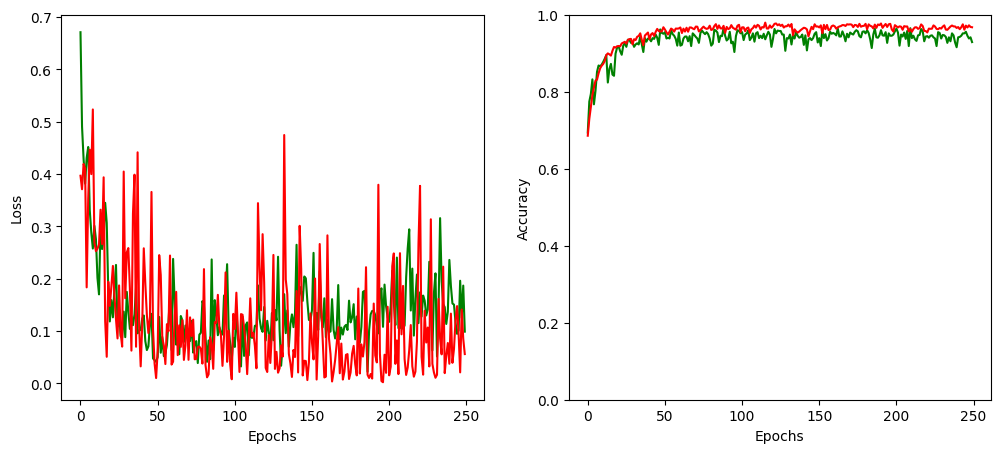

In [ ]:
val_loss=torch.tensor(valloss_history,device = 'cpu'); val_loss_np=val_loss.numpy()
train_loss=torch.tensor(trainloss_history,device = 'cpu');train_loss_np=train_loss.numpy()
train_acc=torch.tensor(trainacc_history,device = 'cpu');train_acc_np=train_acc.numpy()
val_acc=torch.tensor(valacc_history,device = 'cpu'); val_acc_np=np.array(val_acc)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(val_loss_np,'g');plt.plot(train_loss_np,'r');
plt.ylabel('Loss');plt.xlabel('Epochs')
plt.subplot(122)
plt.plot(val_acc_np,'g');plt.plot(train_acc_np,'r');
plt.ylabel('Accuracy');plt.xlabel('Epochs')
plt.ylim(0,1)

Test accuracy is = 93.59925788497218%


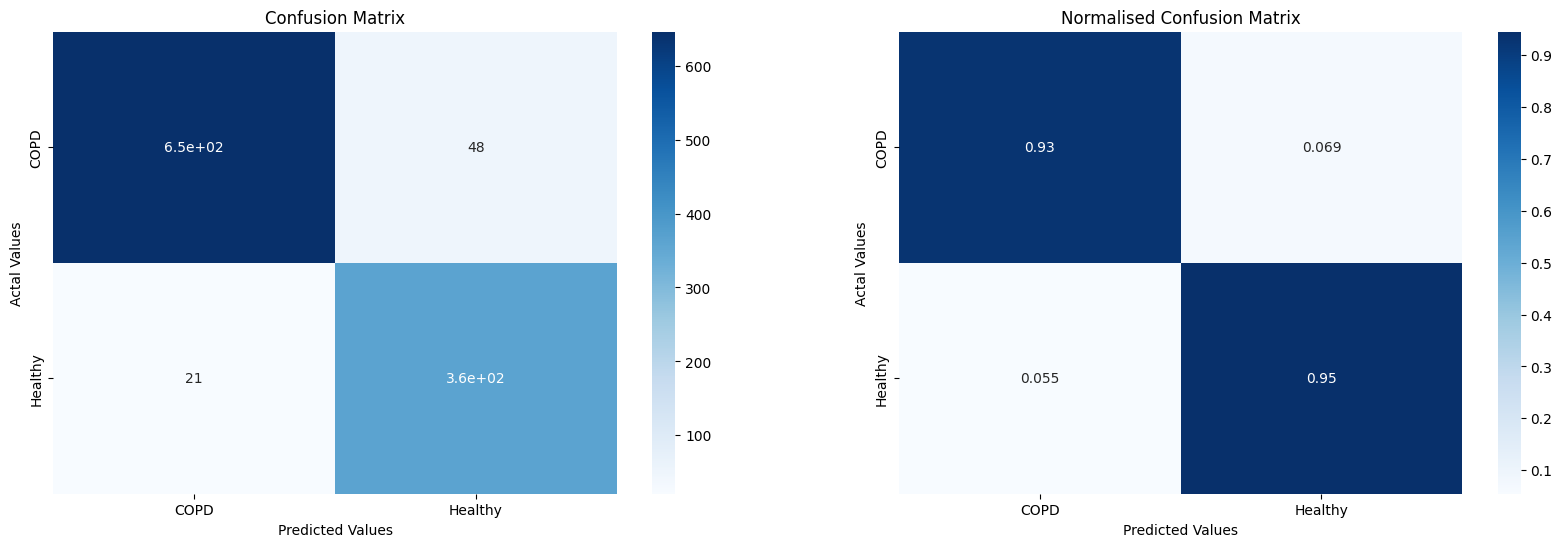

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_true = []
y_pred = []


model.eval()
for xmel_test,xcqt_test, y_tst in (tst_dl):
    xmel_test,xcqt_test=xmel_test.cuda(),xcqt_test.cuda()
    out_test = model(xmel_test,xcqt_test)
    y_hat = F.log_softmax(out_test, dim=1).argmax(dim=1)
    y_hat=y_hat.data.cpu().numpy()
    y_pred.extend(y_hat) # Save preds

    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth


from sklearn.metrics import confusion_matrix
import seaborn as sns;
cm=confusion_matrix(y_true,y_pred)
Acc=cm.trace()/np.sum(cm)
print('Test accuracy is = '+str(Acc*100)+'%')
cm_norm=confusion_matrix(y_true,y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['COPD','Healthy'],
                     columns = ['COPD','Healthy'])
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['COPD','Healthy'],
                     columns = ['COPD','Healthy'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
activation = {}
def get_activation(name):
    def hook(model1, input, output):
        activation[name] = output.detach()
    return hook
model1.linear1.register_forward_hook(get_activation('linear1'))


FEATS = []
y_true = []
# placeholder for batch features
features = {}
for xmel_tst,xcqt_tst,y_tst in tst_dl:
    xmel_tst,xcqt_tst = xmel_tst.cuda(),xcqt_tst.cuda()
    out = model1(xmel_tst,xcqt_tst)
    fea=activation['linear1'].data.cpu().numpy()
    #print('feature tensor shape:',fea.shape)
    FEATS.append(fea)
    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth

FEATS = np.concatenate(FEATS)
y_true=np.array(y_true)
print('feats shape:', FEATS.shape)
print('label shape:', y_true.shape)

feats shape: (1078, 100)
label shape: (1078,)


[Text(0.5, 1.0, 'T-SNE projection for test case DS2ONN Melspectrogram + CQT')]

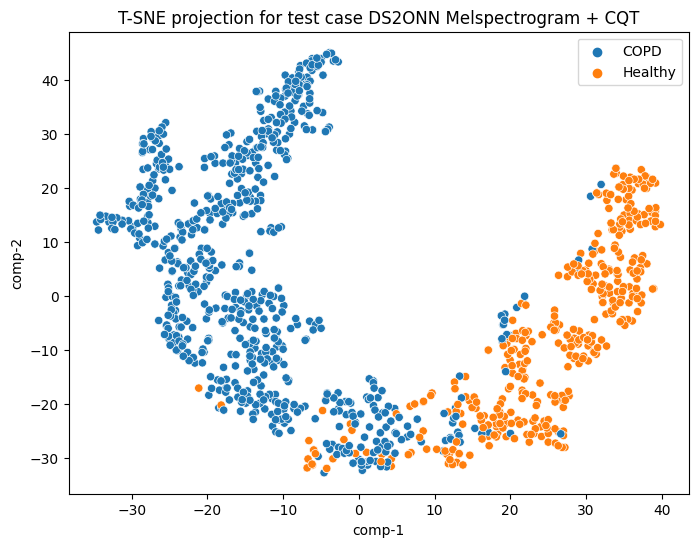

In [ ]:
q=y_true
label_l=[]
for i in range (q.shape[0]):
  if q[i]==0:
    label_l.append('COPD')
  elif q[i]==1:
    label_l.append('Healthy')

Label_ar=np.array(label_l)

import seaborn as sns;
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,learning_rate='auto',init='random')
def scatter(x, labels):
    # We create a scatter plot.
    plt.figure(figsize=(10,8))
    sns.scatterplot(x[:,0], x[:,1], hue=labels,palette="deep")
    plt.xlabel("Dimension 1",fontweight ='bold', fontsize = 15);plt.ylabel("Dimenssion 2",fontweight ='bold', fontsize = 15)
Y_embedded = tsne.fit_transform(FEATS)

df = pd.DataFrame()
df["Labels"] = Label_ar
df["comp-1"] = Y_embedded[:,0]
df["comp-2"] = Y_embedded[:,1]
import seaborn as sns
plt.figure(figsize=(8,6))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.Labels.tolist(),
                data=df).set(title="T-SNE projection for test case DS2ONN Melspectrogram + CQT")

# **BL3: Dual Stream SONN Based Analysis (CQT and MFCC)**

***Data loading helper functions***

In [ ]:
from sklearn.model_selection import train_test_split
def create_datasets(Xmfcc,Xcqt, y, test_size=0.15,seed=None):
    Xmfcc_train1,Xmfcc_test,Xcqt_train1,Xcqt_test, y_train1, y_test = train_test_split(Xmfcc,Xcqt, Y, test_size=0.1,random_state=seed)
    print(y_test.shape)
    Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid, y_train, y_valid = train_test_split(Xmfcc_train1,Xcqt_train1, y_train1, test_size=0.1,random_state=seed)
    Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid,Xmfcc_test,Xcqt_test = [torch.tensor(arr, dtype=torch.float32) for arr in (Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid,Xmfcc_test,Xcqt_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(Xmfcc_train,Xcqt_train, y_train)
    valid_ds = TensorDataset(Xmfcc_valid,Xcqt_valid, y_valid)
    test_ds= TensorDataset(Xmfcc_test,Xcqt_test, y_test)
    return train_ds, valid_ds, test_ds

def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=2):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl

bs = 128
print('Preparing datasets')
trn_ds, val_ds, tst_ds = create_datasets(Mfccs_re,CQTs_re,Y,seed=10)
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)

Preparing datasets
(1078,)
Creating data loaders with batch size: 128


In [ ]:
from torch import nn
from torchsummary import summary
out_filter=128
class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1,out_channels=16,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16,out_channels=32,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32,out_channels=out_filter,kernel_size=3,q=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.GAP=nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(2*out_filter, 100)
        self.linear2 = nn.Linear(100, 50)
        self.gelu=nn.GELU()
        self.relu=nn.ReLU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(50, 2)


    def forward(self, mfcc_data, cqt_data):

        # mfcc scale
        x_mfcc = self.onnv1(mfcc_data)
        x_mfcc = self.onnv2(x_mfcc)
        x_mfcc = self.onnv3(x_mfcc)
        x_mfcc_flat=self.GAP(x_mfcc)
        # cqt scale
        x_cqt = self.onnv1(cqt_data)
        x_cqt = self.onnv2(x_cqt)
        x_cqt = self.onnv3(x_cqt)
        x_cqt_flat=self.GAP(x_cqt)

        x_concat = torch.cat(( x_mfcc_flat,x_cqt_flat), dim=1)
        x=self.flatten(x_concat)
        x = self.dropout(x)
        x=self.relu(x)
        x = self.linear1(x)
        x=self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x=self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)
summary(model, [(1, 30,40),(1, 64, 40)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         SelfONN2d-1           [-1, 16, 28, 38]             448
              Tanh-2           [-1, 16, 28, 38]               0
         MaxPool2d-3           [-1, 16, 14, 19]               0
         SelfONN2d-4           [-1, 32, 12, 17]          13,856
              Tanh-5           [-1, 32, 12, 17]               0
         MaxPool2d-6             [-1, 32, 6, 8]               0
         SelfONN2d-7            [-1, 128, 4, 6]         147,584
              Tanh-8            [-1, 128, 4, 6]               0
         MaxPool2d-9            [-1, 128, 2, 3]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
        SelfONN2d-11           [-1, 16, 62, 38]             448
             Tanh-12           [-1, 16, 62, 38]               0
        MaxPool2d-13           [-1, 16, 31, 19]               0
        SelfONN2d-14           [-1, 32,

In [ ]:
lr = 0.008
n_epochs = 149
iterations_per_epoch = len(trn_dl)

trainloss_history = []
valacc_history = []
valloss_history = []
trainacc_history=[]
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)


print('Start model training')

for epoch in range(1, n_epochs + 1):
    correct, total = 0, 0
    for i, (xmfcc_batch,xcqt_batch, y_batch) in enumerate(trn_dl):
        model.train()
        xmfcc_batch,xcqt_batch = xmfcc_batch.cuda(),xcqt_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        out_tr = model(xmfcc_batch,xcqt_batch)
        loss =  criterion(out_tr, y_batch)
        preds_tr = F.log_softmax(out_tr, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds_tr == y_batch).sum().item()
        loss.backward()
        opt.step()
    trainloss_history.append(loss)
    train_acc = correct / total
    trainacc_history.append(train_acc)
    with torch.no_grad():
        model.eval()
        correct, total = 0, 0
        for xmfcc_val,xcqt_val, y_val in (val_dl):
            xmfcc_val,xcqt_val=xmfcc_val.cuda(),xcqt_val.cuda()
            y_val = y_val.cuda()
            out_vl = model(xmfcc_val,xcqt_val)
            valid_loss = criterion(out_vl, y_val)
            preds = F.log_softmax(out_vl, dim=1).argmax(dim=1)
            total += y_val.size(0)
            correct += (preds == y_val).sum().item()
    valloss_history.append(valid_loss)
    valid_acc = correct / total
    valacc_history.append(valid_acc)
    print(f'Epoch: {epoch:3d}. Training Loss: {loss:.4f}. Validation Loss: {valid_loss:.4f}. Training Acc.: {train_acc:2.2%}  Validation Acc.: {valid_acc:2.2%}')

Start model training
Epoch:   1. Training Loss: 0.3907. Validation Loss: 0.6176. Training Acc.: 68.72%  Validation Acc.: 74.97%
Epoch:   2. Training Loss: 0.8328. Validation Loss: 0.5690. Training Acc.: 72.33%  Validation Acc.: 75.08%
Epoch:   3. Training Loss: 0.5341. Validation Loss: 0.5311. Training Acc.: 73.42%  Validation Acc.: 76.62%
Epoch:   4. Training Loss: 0.3994. Validation Loss: 0.5228. Training Acc.: 75.02%  Validation Acc.: 77.55%
Epoch:   5. Training Loss: 0.5621. Validation Loss: 0.5019. Training Acc.: 76.27%  Validation Acc.: 76.62%
Epoch:   6. Training Loss: 0.5364. Validation Loss: 0.4598. Training Acc.: 77.47%  Validation Acc.: 83.63%
Epoch:   7. Training Loss: 0.3062. Validation Loss: 0.4252. Training Acc.: 78.66%  Validation Acc.: 81.46%
Epoch:   8. Training Loss: 0.2663. Validation Loss: 0.4475. Training Acc.: 81.01%  Validation Acc.: 78.89%
Epoch:   9. Training Loss: 0.4070. Validation Loss: 0.4139. Training Acc.: 80.38%  Validation Acc.: 83.73%
Epoch:  10. Trai

In [ ]:
val_loss=torch.tensor(valloss_history,device = 'cpu'); val_loss_np=val_loss.numpy()
train_loss=torch.tensor(trainloss_history,device = 'cpu');train_loss_np=train_loss.numpy()
train_acc=torch.tensor(trainacc_history,device = 'cpu');train_acc_np=train_acc.numpy()
val_acc=torch.tensor(valacc_history,device = 'cpu'); val_acc_np=np.array(val_acc)

(0.0, 1.0)

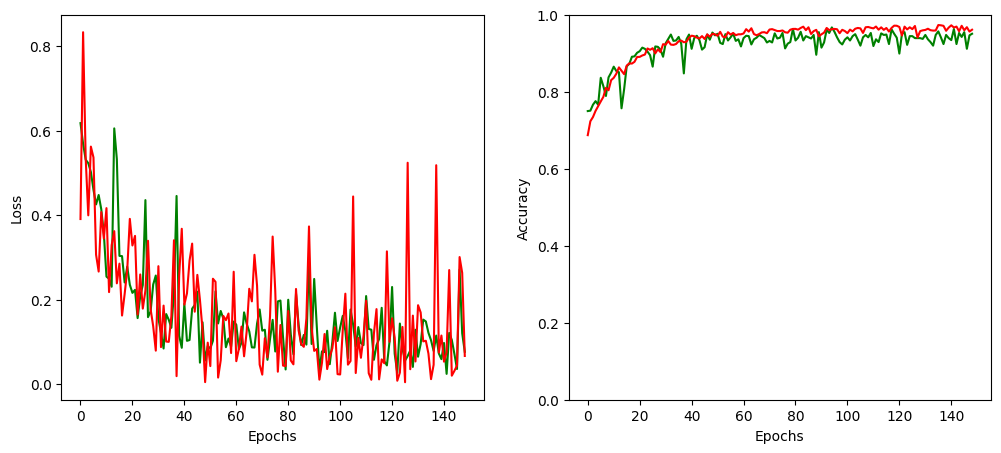

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(val_loss_np,'g');plt.plot(train_loss_np,'r');
plt.ylabel('Loss');plt.xlabel('Epochs')
plt.subplot(122)
plt.plot(val_acc_np,'g');plt.plot(train_acc_np,'r');
plt.ylabel('Accuracy');plt.xlabel('Epochs')
plt.ylim(0,1)

Test accuracy is = 94.15584415584416%


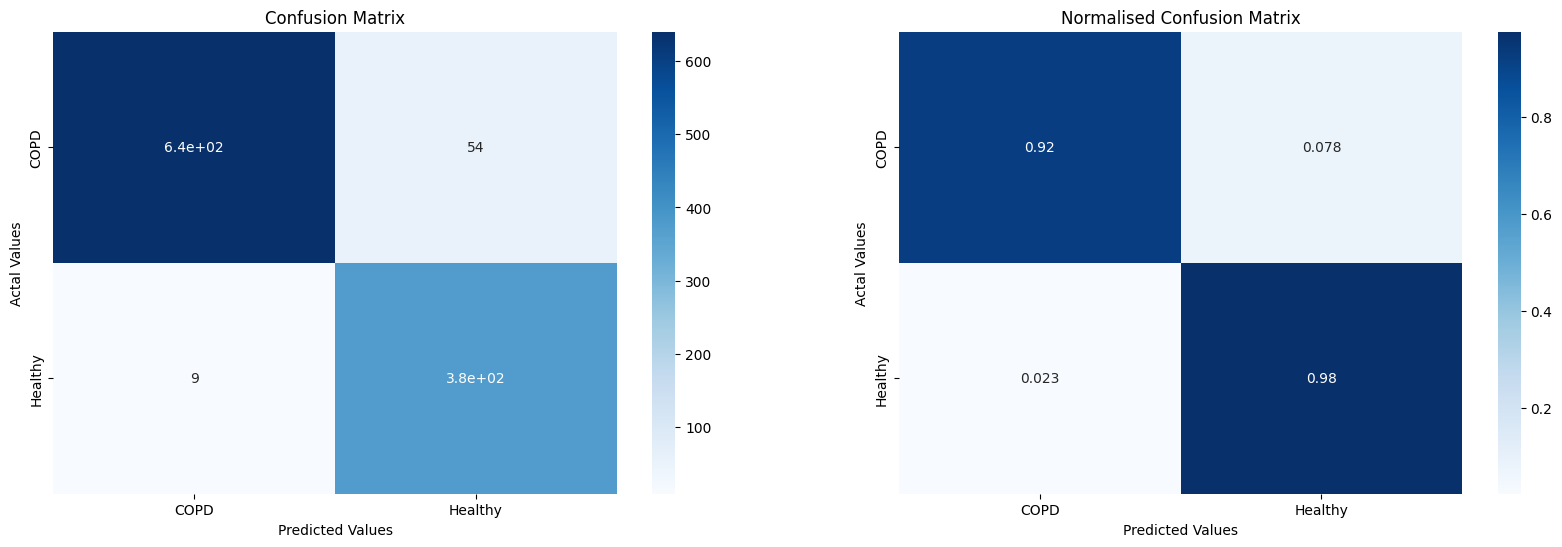

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_true = []
y_pred = []

#model.load_state_dict(torch.load('/content/gdrive/MyDrive/ARKA/Asthma_classification/ONN_Results/onn_scatter.pth'))
model.eval()
for xmfcc_test,xcqt_test, y_tst in (tst_dl):
    xmfcc_test,xcqt_test=xmfcc_test.cuda(),xcqt_test.cuda()
    out_test = model(xmfcc_test,xcqt_test)
    y_hat = F.log_softmax(out_test, dim=1).argmax(dim=1)
    y_hat=y_hat.data.cpu().numpy()
    y_pred.extend(y_hat) # Save preds

    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth


from sklearn.metrics import confusion_matrix
import seaborn as sns;
cm=confusion_matrix(y_true,y_pred)
Acc=cm.trace()/np.sum(cm)
print('Test accuracy is = '+str(Acc*100)+'%')
cm_norm=confusion_matrix(y_true,y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['COPD','Healthy'],
                     columns = ['COPD','Healthy'])
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['COPD','Healthy'],
                     columns = ['COPD','Healthy'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.linear2.register_forward_hook(get_activation('linear2'))


FEATS = []
y_true = []
# placeholder for batch features
features = {}
for xmfcc_tst,xcqt_tst,y_tst in tst_dl:
    xmfcc_tst,xcqt_tst =xmfcc_tst.cuda(),xcqt_tst.cuda()
    out = model(xmfcc_tst,xcqt_tst)
    fea=activation['linear2'].data.cpu().numpy()
    #print('feature tensor shape:',fea.shape)
    FEATS.append(fea)
    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth

FEATS = np.concatenate(FEATS)
y_true=np.array(y_true)
print('feats shape:', FEATS.shape)
print('label shape:', y_true.shape)

feats shape: (1078, 50)
label shape: (1078,)


[Text(0.5, 1.0, 'T-SNE projection for test case DS2ONN MFCC + CQT')]

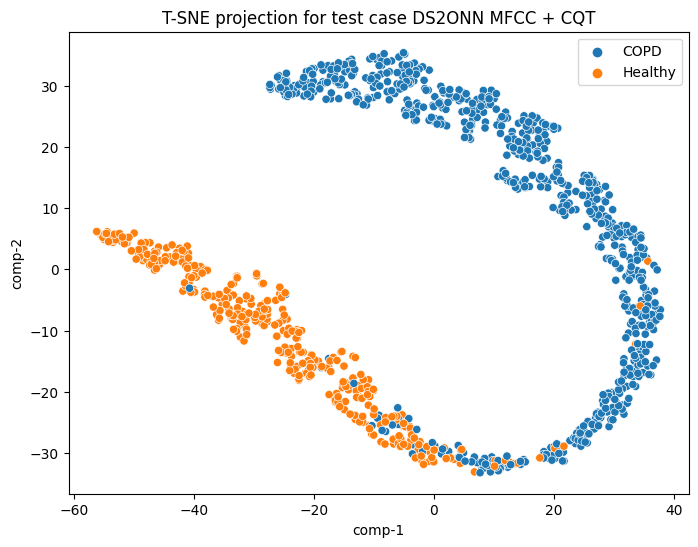

In [ ]:
q=y_true
label_l=[]
for i in range (q.shape[0]):
  if q[i]==0:
    label_l.append('COPD')
  elif q[i]==1:
    label_l.append('Healthy')

Label_ar=np.array(label_l)

import seaborn as sns;
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,learning_rate='auto',init='random')
def scatter(x, labels):
    # We create a scatter plot.
    plt.figure(figsize=(10,8))
    sns.scatterplot(x[:,0], x[:,1], hue=labels,palette="deep")
    plt.xlabel("Dimension 1",fontweight ='bold', fontsize = 15);plt.ylabel("Dimenssion 2",fontweight ='bold', fontsize = 15)
Y_embedded = tsne.fit_transform(FEATS)

df = pd.DataFrame()
df["Labels"] = Label_ar
df["comp-1"] = Y_embedded[:,0]
df["comp-2"] = Y_embedded[:,1]
import seaborn as sns
plt.figure(figsize=(8,6))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.Labels.tolist(),
                data=df).set(title="T-SNE projection for test case DS2ONN MFCC + CQT")

# **BL3: Dual Stream SONN Based Analysis (Melspectrogram and MFCC)**

***Data loading helper functions***

In [ ]:
from sklearn.model_selection import train_test_split
def create_datasets(Xmel,Xmfcc, y, test_size=0.15,seed=None):
    Xmel_train1, Xmel_test, Xmfcc_train1,Xmfcc_test, y_train1, y_test = train_test_split(Xmel,Xmfcc, Y, test_size=0.1,random_state=seed)
    print(y_test.shape)
    Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid, y_train, y_valid = train_test_split(Xmel_train1, Xmfcc_train1, y_train1, test_size=0.1,random_state=seed)
    Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid, Xmel_test, Xmfcc_test = [torch.tensor(arr, dtype=torch.float32) for arr in (Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid, Xmel_test, Xmfcc_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(Xmel_train,Xmfcc_train, y_train)
    valid_ds = TensorDataset(Xmel_valid,Xmfcc_valid, y_valid)
    test_ds= TensorDataset(Xmel_test,Xmfcc_test, y_test)
    return train_ds, valid_ds, test_ds

def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=2):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl

bs = 128
print('Preparing datasets')
trn_ds, val_ds, tst_ds = create_datasets(Melspecs_re, Mfccs_re, Y,seed=10)
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)

Preparing datasets
(1078,)
Creating data loaders with batch size: 128


In [ ]:
from torch import nn
from torchsummary import summary
out_filter=128
class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1,out_channels=16,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16,out_channels=32,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32,out_channels=out_filter,kernel_size=3,q=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.GAP=nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(2*out_filter, 100)
        self.linear2 = nn.Linear(100, 50)
        self.gelu=nn.GELU()
        self.relu=nn.ReLU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(50, 2)


    def forward(self, melspec_data, mfcc_data):
        # melspectrogram scale
        x_mel = self.onnv1(melspec_data)
        x_mel = self.onnv2(x_mel)
        x_mel = self.onnv3(x_mel)
        x_mel_flat=self.GAP(x_mel)
        # mfcc scale
        x_mfcc = self.onnv1(mfcc_data)
        x_mfcc = self.onnv2(x_mfcc)
        x_mfcc = self.onnv3(x_mfcc)
        x_mfcc_flat=self.GAP(x_mfcc)


        x_concat = torch.cat((x_mel_flat, x_mfcc_flat), dim=1)
        x=self.flatten(x_concat)
        x = self.dropout(x)
        x=self.relu(x)
        x = self.linear1(x)
        x=self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x=self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)
summary(model, [(1, 64, 39),(1, 30,40)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         SelfONN2d-1           [-1, 16, 62, 37]             448
              Tanh-2           [-1, 16, 62, 37]               0
         MaxPool2d-3           [-1, 16, 31, 18]               0
         SelfONN2d-4           [-1, 32, 29, 16]          13,856
              Tanh-5           [-1, 32, 29, 16]               0
         MaxPool2d-6            [-1, 32, 14, 8]               0
         SelfONN2d-7           [-1, 128, 12, 6]         147,584
              Tanh-8           [-1, 128, 12, 6]               0
         MaxPool2d-9            [-1, 128, 6, 3]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
        SelfONN2d-11           [-1, 16, 28, 38]             448
             Tanh-12           [-1, 16, 28, 38]               0
        MaxPool2d-13           [-1, 16, 14, 19]               0
        SelfONN2d-14           [-1, 32,

In [ ]:
lr = 0.003
n_epochs = 100
iterations_per_epoch = len(trn_dl)

trainloss_history = []
valacc_history = []
valloss_history = []
trainacc_history=[]
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)


print('Start model training')

for epoch in range(1, n_epochs + 1):
    correct, total = 0, 0
    for i, (xmel_batch,xmfcc_batch, y_batch) in enumerate(trn_dl):
        model.train()
        xmel_batch,xmfcc_batch = xmel_batch.cuda(),xmfcc_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        out_tr = model(xmel_batch,xmfcc_batch)
        loss =  criterion(out_tr, y_batch)
        preds_tr = F.log_softmax(out_tr, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds_tr == y_batch).sum().item()
        loss.backward()
        opt.step()
    trainloss_history.append(loss)
    train_acc = correct / total
    trainacc_history.append(train_acc)
    with torch.no_grad():
        model.eval()
        correct, total = 0, 0
        for xmel_val,xmfcc_val, y_val in (val_dl):
            xmel_val,xmfcc_val=xmel_val.cuda(),xmfcc_val.cuda()
            y_val = y_val.cuda()
            out_vl = model(xmel_val,xmfcc_val)
            valid_loss = criterion(out_vl, y_val)
            preds = F.log_softmax(out_vl, dim=1).argmax(dim=1)
            total += y_val.size(0)
            correct += (preds == y_val).sum().item()
    valloss_history.append(valid_loss)
    valid_acc = correct / total
    valacc_history.append(valid_acc)
    print(f'Epoch: {epoch:3d}. Training Loss: {loss:.4f}. Validation Loss: {valid_loss:.4f}. Training Acc.: {train_acc:2.2%}  Validation Acc.: {valid_acc:2.2%}')

Start model training
Epoch:   1. Training Loss: 0.6382. Validation Loss: 0.5114. Training Acc.: 65.63%  Validation Acc.: 72.50%
Epoch:   2. Training Loss: 0.5071. Validation Loss: 0.4322. Training Acc.: 74.33%  Validation Acc.: 81.05%
Epoch:   3. Training Loss: 0.4418. Validation Loss: 0.3704. Training Acc.: 77.00%  Validation Acc.: 83.21%
Epoch:   4. Training Loss: 0.3302. Validation Loss: 0.4869. Training Acc.: 80.98%  Validation Acc.: 80.54%
Epoch:   5. Training Loss: 0.3832. Validation Loss: 0.3533. Training Acc.: 81.64%  Validation Acc.: 85.38%
Epoch:   6. Training Loss: 0.3401. Validation Loss: 0.3661. Training Acc.: 82.49%  Validation Acc.: 84.35%
Epoch:   7. Training Loss: 0.3233. Validation Loss: 0.3978. Training Acc.: 83.80%  Validation Acc.: 83.73%
Epoch:   8. Training Loss: 0.3723. Validation Loss: 0.3645. Training Acc.: 83.83%  Validation Acc.: 86.10%
Epoch:   9. Training Loss: 0.3998. Validation Loss: 0.3444. Training Acc.: 84.40%  Validation Acc.: 86.71%
Epoch:  10. Trai

(0.0, 1.0)

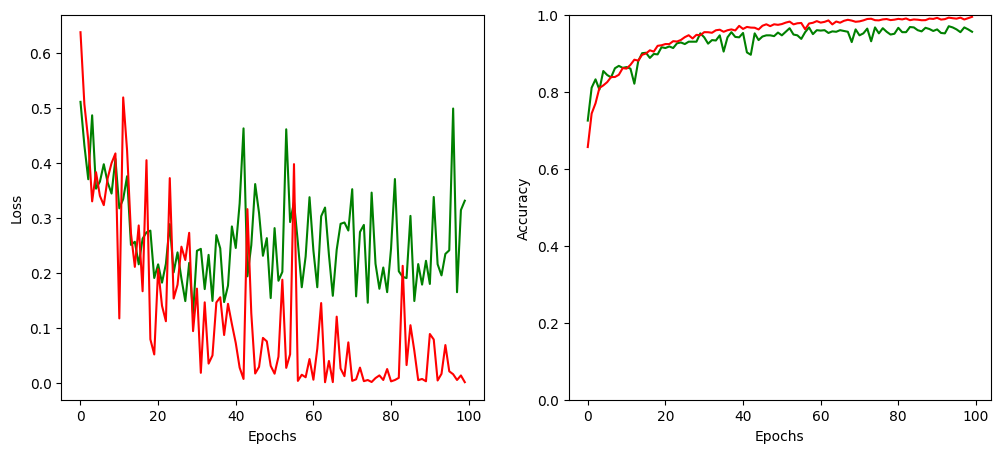

In [ ]:
val_loss=torch.tensor(valloss_history,device = 'cpu'); val_loss_np=val_loss.numpy()
train_loss=torch.tensor(trainloss_history,device = 'cpu');train_loss_np=train_loss.numpy()
train_acc=torch.tensor(trainacc_history,device = 'cpu');train_acc_np=train_acc.numpy()
val_acc=torch.tensor(valacc_history,device = 'cpu'); val_acc_np=np.array(val_acc)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(val_loss_np,'g');plt.plot(train_loss_np,'r');
plt.ylabel('Loss');plt.xlabel('Epochs')
plt.subplot(122)
plt.plot(val_acc_np,'g');plt.plot(train_acc_np,'r');
plt.ylabel('Accuracy');plt.xlabel('Epochs')
plt.ylim(0,1)

Test accuracy is = 95.73283858998145%


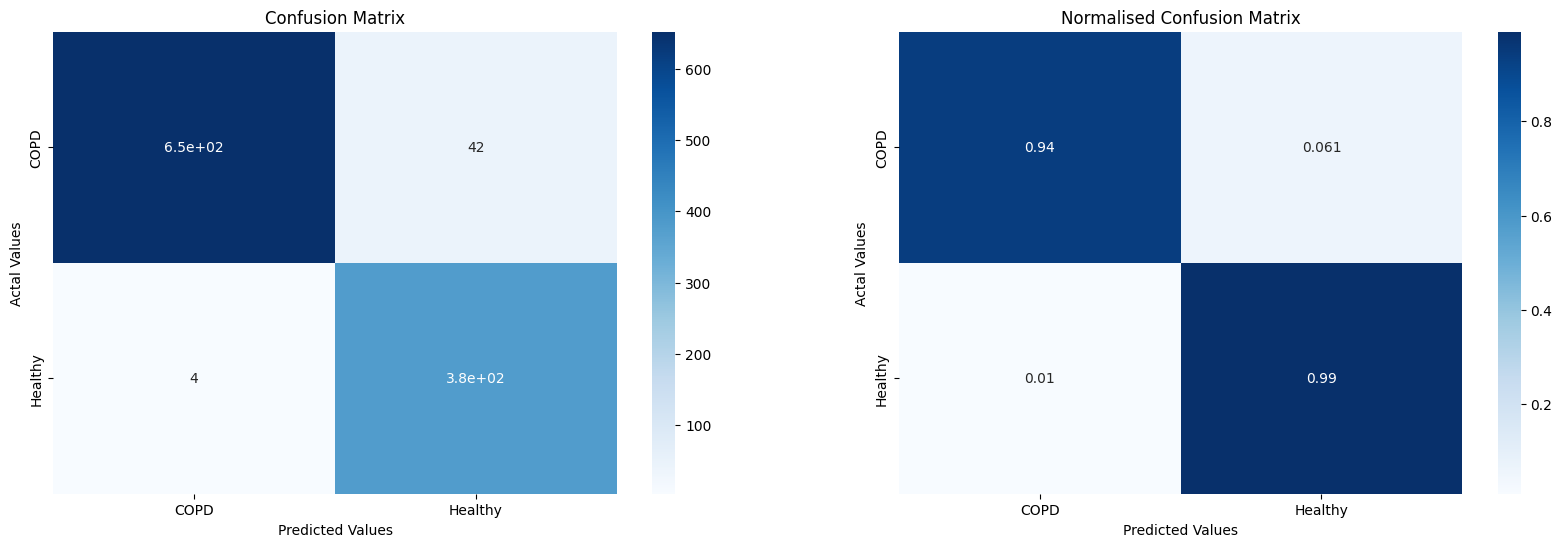

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_true = []
y_pred = []

model.eval()
for xmel_test,xmfcc_test, y_tst in (tst_dl):
    xmel_test,xmfcc_test=xmel_test.cuda(),xmfcc_test.cuda()
    out_test = model(xmel_test,xmfcc_test)
    y_hat = F.log_softmax(out_test, dim=1).argmax(dim=1)
    y_hat=y_hat.data.cpu().numpy()
    y_pred.extend(y_hat) # Save preds

    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth


from sklearn.metrics import confusion_matrix
import seaborn as sns;
cm=confusion_matrix(y_true,y_pred)
Acc=cm.trace()/np.sum(cm)
print('Test accuracy is = '+str(Acc*100)+'%')
cm_norm=confusion_matrix(y_true,y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['COPD','Healthy'],
                     columns = ['COPD','Healthy'])
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['COPD','Healthy'],
                     columns = ['COPD','Healthy'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.linear2.register_forward_hook(get_activation('linear2'))


FEATS = []
y_true = []
# placeholder for batch features
features = {}
for xmel_tst,xmfcc_tst,y_tst in tst_dl:
    xmel_tst,xmfcc_tst = xmel_tst.cuda(),xmfcc_tst.cuda()
    out = model(xmel_tst,xmfcc_tst)
    fea=activation['linear2'].data.cpu().numpy()
    #print('feature tensor shape:',fea.shape)
    FEATS.append(fea)
    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth

FEATS = np.concatenate(FEATS)
y_true=np.array(y_true)
print('feats shape:', FEATS.shape)
print('label shape:', y_true.shape)

feats shape: (1078, 50)
label shape: (1078,)


[Text(0.5, 1.0, 'T-SNE projection for test case DS2ONN Melspectrogram + MFCC')]

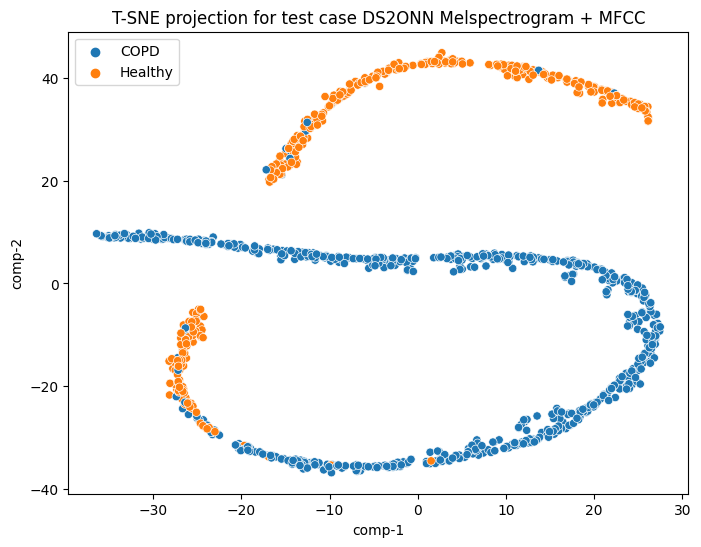

In [ ]:
q=y_true
label_l=[]
for i in range (q.shape[0]):
  if q[i]==0:
    label_l.append('COPD')
  elif q[i]==1:
    label_l.append('Healthy')

Label_ar=np.array(label_l)

import seaborn as sns;
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,learning_rate='auto',init='random')
def scatter(x, labels):
    # We create a scatter plot.
    plt.figure(figsize=(10,8))
    sns.scatterplot(x[:,0], x[:,1], hue=labels,palette="deep")
    plt.xlabel("Dimension 1",fontweight ='bold', fontsize = 15);plt.ylabel("Dimenssion 2",fontweight ='bold', fontsize = 15)
Y_embedded = tsne.fit_transform(FEATS)

df = pd.DataFrame()
df["Labels"] = Label_ar
df["comp-1"] = Y_embedded[:,0]
df["comp-2"] = Y_embedded[:,1]
import seaborn as sns
plt.figure(figsize=(8,6))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.Labels.tolist(),
                data=df).set(title="T-SNE projection for test case DS2ONN Melspectrogram + MFCC")

# **Compare with Transfer Learning Models**

In [ ]:
import cv2 as cvlib
import librosa
import scipy.io as sio
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import tensorflow as tf
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow import keras
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Dropout,Flatten, Lambda,BatchNormalization, Activation, Input, DepthwiseConv2D,MaxPool2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import activations
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import matplotlib.figure
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from pytz import timezone
from datetime import datetime

In [ ]:
labels=pd.read_excel('/content/gdrive/MyDrive/ARKA/7class_disease_work/7class_labels.xlsx',header=None)
l=np.array(labels);copd_labels=l[4525:11166];healthy_labels=l[11167:15306];
all_labels=np.concatenate((copd_labels,healthy_labels), axis=0)
label_df=pd.DataFrame(all_labels,columns=['Lung_sounds'])
y_onehot=pd.get_dummies(label_df)
y_onehot=np.array(y_onehot)

In [ ]:
import pickle
def load_pickle_file(name_of_file):
    infile = open(name_of_file,'rb')
    wgt = pickle.load(infile)
    infile.close()
    print('=========loading done=========')
    return wgt

Melspecs= load_pickle_file('/content/gdrive/MyDrive/ARKA/COPD_MSONN/Melspecs_copd_healthy')
Mfccs= load_pickle_file('/content/gdrive/MyDrive/ARKA/COPD_MSONN/Mfccs_copd_healthy')
CQTs= load_pickle_file('/content/gdrive/MyDrive/ARKA/COPD_MSONN/CQTs_copd_healthy')

=========loading done=========
=========loading done=========
=========loading done=========


In [ ]:
mel_rgb_list=[];cqt_rgb_list=[];mfcc_rgb_list=[];
d_shape=64;
import cv2 as cvlib
for i in range (Melspecs.shape[0]):
    mel_img = Melspecs[i,:,:]
    mel_img=cvlib.resize(mel_img, dsize=(d_shape,d_shape), interpolation=cvlib.INTER_CUBIC)
    cmap = plt.get_cmap('jet')
    mel_rgba_img = cmap(mel_img)
    mel_rgb_img = np.delete(mel_rgba_img, 3, 2)
    mel_clip_rgb=np.flip(mel_rgb_img, 0)
    mel_rgb_list.append(mel_clip_rgb)
for i in range (Mfccs.shape[0]):
    mfcc_img = Mfccs[i,:,:]
    mfcc_img=cvlib.resize(mfcc_img, dsize=(d_shape,d_shape), interpolation=cvlib.INTER_CUBIC)
    cmap = plt.get_cmap('jet')
    mfcc_rgba_img = cmap(mfcc_img)
    mfcc_rgb_img = np.delete(mfcc_rgba_img, 3, 2)
    mfcc_clip_rgb=np.flip(mfcc_rgb_img, 0)
    mfcc_rgb_list.append(mfcc_clip_rgb)
for i in range (CQTs.shape[0]):
    cqt_img = CQTs[i,:,:]
    cqt_img=cvlib.resize(cqt_img, dsize=(d_shape,d_shape), interpolation=cvlib.INTER_CUBIC)
    cmap = plt.get_cmap('jet')
    cqt_rgba_img = cmap(cqt_img)
    cqt_rgb_img = np.delete(cqt_rgba_img, 3, 2)
    cqt_clip_rgb=np.flip(cqt_rgb_img, 0)
    cqt_rgb_list.append(cqt_clip_rgb)
Xmel=np.array(mel_rgb_list);Xmfcc=np.array(mfcc_rgb_list);Xcqt=np.array(cqt_rgb_list);

## **VGG-16 based transfer learning**

In [ ]:
import tensorflow.keras as K
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_data(X):
    """pre-processes the data"""
    X_p  = preprocess_input(X)
    return X_p

Xmel=preprocess_data(Xmel)
Xmfcc=preprocess_data(Xmfcc)
Xcqt=preprocess_data(Xcqt)

p=10
Xmel_train1, Xmel_test, Xmfcc_train1,Xmfcc_test,Xcqt_train1,Xcqt_test, y_train1, y_test = train_test_split(Xmel,Xmfcc,Xcqt, y_onehot, test_size=0.1,random_state=p)
Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid, y_train, y_valid = train_test_split(Xmel_train1,Xmfcc_train1,Xcqt_train1, y_train1, test_size=0.1,random_state=p)
input_t = K.Input(shape=(64,64,3))
VGGModel = VGG16(include_top=False,weights='imagenet',input_tensor=input_t)
for layer in VGGModel.layers[:149]:
    layer.trainable = False
for layer in VGGModel.layers[149:]:
    layer.trainable = True

58889256/58889256 [==============================] - 5s 0us/step


In [ ]:
def vgg_transfer(output_neurons,output_activation):
    # Melspectrogram input model
    Melspec_ip= Input(shape=(64,64,3),name="Melspec_Input")
    x_mel= VGGModel(Melspec_ip)
    x_mel=tf.keras.layers.GlobalAveragePooling2D()(x_mel)
    # MFCC input model
    Mfcc_ip= Input(shape=(64,64,3),name="Mfcc_Input")
    x_mfcc= VGGModel(Mfcc_ip)
    x_mfcc=tf.keras.layers.GlobalAveragePooling2D()(x_mfcc)
    # CQT input model
    CQT_ip= Input(shape=(64,64,3),name="CQT_Input")
    x_cqt= VGGModel(CQT_ip)
    x_cqt=tf.keras.layers.GlobalAveragePooling2D()(x_cqt)

    # concatenate all the multiscale embeddings
    x_cat= tf.keras.layers.Concatenate()([x_mel, x_mfcc, x_cqt])
    t1=Dropout(0.3)(x_cat)
    t1= Dense(150, 'gelu')(t1)
    t1=Dropout(0.3)(t1)
    t1= Dense(100,'gelu')(t1)
    t1=Dropout(0.3)(t1)
    output = Dense(output_neurons, output_activation)(t1)
    model = tf.keras.Model(inputs = [Melspec_ip,Mfcc_ip,CQT_ip], outputs = output)
    return model

output_neurons=2;
output_activation='sigmoid'
VGGTransferModel= vgg_transfer(output_neurons,output_activation)
VGGTransferModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Melspec_Input (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Mfcc_Input (InputLayer)        [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 CQT_Input (InputLayer)         [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 vgg16 (Functional)             (None, 2, 2, 512)    14714688    ['Melspec_Input[0][0]',          
                                                                  'Mfcc_Input[0][0]',         

In [ ]:
output_neurons=2;
output_activation='sigmoid'
VGGTransferModel= vgg_transfer(output_neurons,output_activation)
opt =tf.keras.optimizers.Adam(learning_rate=0.001)
VGGTransferModel.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
history =VGGTransferModel.fit([Xmel_train,Xmfcc_train,Xcqt_train], y_train, batch_size=128, epochs=150, verbose=1,
                        validation_data=([Xmel_valid,Xmfcc_valid,Xcqt_valid], y_valid))

Epoch 1/150
69/69 [==============================] - 27s 217ms/step - loss: 1.0075 - accuracy: 0.5577 - val_loss: 0.6793 - val_accuracy: 0.6334
Epoch 2/150
69/69 [==============================] - 10s 140ms/step - loss: 0.6942 - accuracy: 0.5858 - val_loss: 0.6671 - val_accuracy: 0.6334
Epoch 3/150
69/69 [==============================] - 10s 142ms/step - loss: 0.6801 - accuracy: 0.6036 - val_loss: 0.6613 - val_accuracy: 0.6334
Epoch 4/150
69/69 [==============================] - 10s 144ms/step - loss: 0.6744 - accuracy: 0.6083 - val_loss: 0.6590 - val_accuracy: 0.6334
Epoch 5/150
69/69 [==============================] - 10s 147ms/step - loss: 0.6738 - accuracy: 0.6093 - val_loss: 0.6588 - val_accuracy: 0.6334
Epoch 6/150
69/69 [==============================] - 10s 150ms/step - loss: 0.6734 - accuracy: 0.6105 - val_loss: 0.6590 - val_accuracy: 0.6334
Epoch 7/150
69/69 [==============================] - 11s 154ms/step - loss: 0.6716 - accuracy: 0.6100 - val_loss: 0.6572 - val_accuracy:

<Figure size 640x480 with 0 Axes>

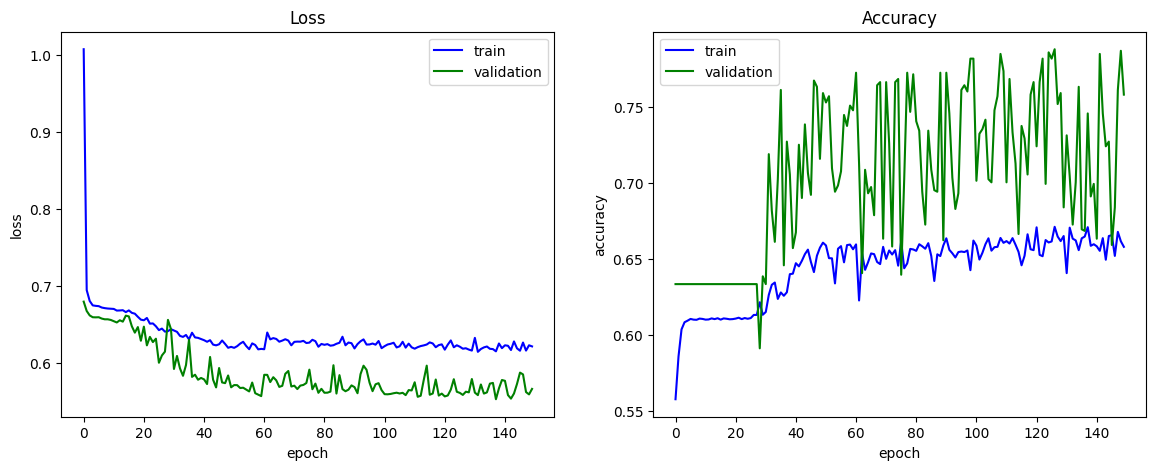

In [ ]:
plt.figure(1)
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['loss'],'b-')
plt.plot(history.history['val_loss'],'g-')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')

plt.subplot(122)
plt.plot(history.history['accuracy'],'b-')
plt.plot(history.history['val_accuracy'],'g-')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
results=VGGTransferModel.evaluate([Xmel_test,Xmfcc_test,Xcqt_test],y_test,batch_size=128,verbose=1)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

9/9 [==============================] - 4s 461ms/step - loss: 0.5749 - accuracy: 0.7282
Test loss: 0.5749403238296509
Test accuracy: 0.728200376033783


[[529 165]
 [128 256]]


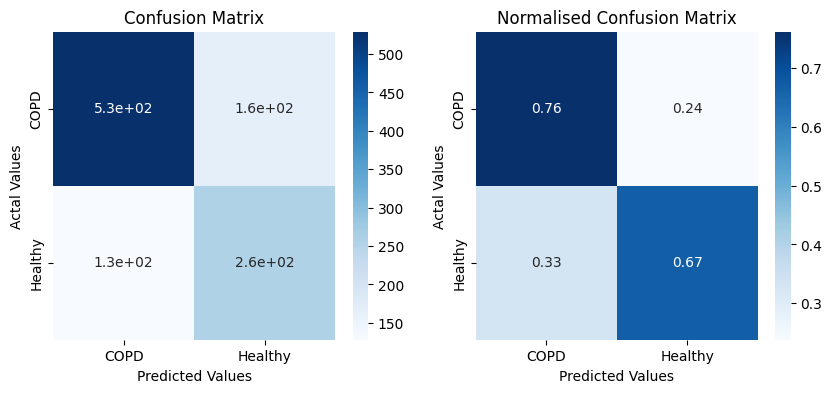

In [ ]:
from tqdm import tqdm
# prediction using CNN
predicted=VGGTransferModel.predict([Xmel_test,Xmfcc_test,Xcqt_test],batch_size=128,verbose=0)
Y_pred=predicted.argmax(axis=-1)
Y_original=pd.DataFrame(y_test,columns=['COPD','Healthy'])
Y_ori=[];copd_t=0;Normal_t=0;
for index,row in tqdm(Y_original.iterrows()):
    if row['COPD']==1:
        copd_t=copd_t+1
        Y_ori.append(0)
    elif row['Healthy']==1:
        Normal_t=Normal_t+1
        Y_ori.append(1)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_ori,Y_pred)
cm_norm=confusion_matrix(Y_ori,Y_pred,normalize='true')
print(cm)
cm_df = pd.DataFrame(cm,
                     index = ['COPD','Healthy'],
                     columns = ['COPD','Healthy'])
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['COPD','Healthy'],
                     columns = ['COPD','Healthy'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()



## **Resnet-50 based transfer learning**

In [ ]:
import tensorflow.keras as K
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess_data(X):
    """pre-processes the data"""
    X_p  = preprocess_input(X)
    return X_p

Xmel=preprocess_data(Xmel)
Xmfcc=preprocess_data(Xmfcc)
Xcqt=preprocess_data(Xcqt)

p=5
Xmel_train1, Xmel_test, Xmfcc_train1,Xmfcc_test,Xcqt_train1,Xcqt_test, y_train1, y_test = train_test_split(Xmel,Xmfcc,Xcqt, y_onehot, test_size=0.1,random_state=p)
Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid, y_train, y_valid = train_test_split(Xmel_train1,Xmfcc_train1,Xcqt_train1, y_train1, test_size=0.1,random_state=p)

input_t = K.Input(shape=(64, 64, 3))
res_model = K.applications.ResNet50(include_top=False,weights="imagenet",input_tensor=input_t)
for layer in res_model.layers[:]:
    layer.trainable = False

for i, layer in enumerate(res_model.layers) :
    print(i, layer.name, "-", layer.trainable)

94765736/94765736 [==============================] - 5s 0us/step
0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn

In [ ]:
def res_transfer(output_neurons,output_activation):
    # Melspectrogram input model
    Melspec_ip= Input(shape=(64,64,3),name="Melspec_Input")
    x_mel= res_model(Melspec_ip)
    x_mel=tf.keras.layers.GlobalAveragePooling2D()(x_mel)
    # MFCC input model
    Mfcc_ip= Input(shape=(64,64,3),name="Mfcc_Input")
    x_mfcc= res_model(Mfcc_ip)
    x_mfcc=tf.keras.layers.GlobalAveragePooling2D()(x_mfcc)
    # CQT input model
    CQT_ip= Input(shape=(64,64,3),name="CQT_Input")
    x_cqt= res_model(CQT_ip)
    x_cqt=tf.keras.layers.GlobalAveragePooling2D()(x_cqt)

    # concatenate all the multiscale embeddings
    x_cat= tf.keras.layers.Concatenate()([x_mel, x_mfcc, x_cqt])
    t1=Dropout(0.3)(x_cat)
    t1= Dense(150, 'gelu')(t1)
    t1=Dropout(0.3)(t1)
    t1= Dense(100,'gelu')(t1)
    t1=Dropout(0.3)(t1)
    output = Dense(output_neurons, output_activation)(t1)
    model = tf.keras.Model(inputs = [Melspec_ip,Mfcc_ip,CQT_ip], outputs = output)
    return model

output_neurons=2;
output_activation='softmax'
resTransferModel= res_transfer(output_neurons,output_activation)
resTransferModel.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Melspec_Input (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Mfcc_Input (InputLayer)        [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 CQT_Input (InputLayer)         [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 resnet50 (Functional)          (None, 2, 2, 2048)   23587712    ['Melspec_Input[0][0]',          
                                                                  'Mfcc_Input[0][0]',       

In [ ]:
opt =tf.keras.optimizers.Adam(learning_rate=0.01)
resTransferModel.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
history =resTransferModel.fit([Xmel_train,Xmfcc_train,Xcqt_train], y_train, batch_size=128, epochs=150, verbose=1,
                        validation_data=([Xmel_valid,Xmfcc_valid,Xcqt_valid], y_valid))

In [ ]:
results=resTransferModel.evaluate([Xmel_test,Xmfcc_test,Xcqt_test],y_test,batch_size=128,verbose=1)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

9/9 [==============================] - 1s 161ms/step - loss: 0.4034 - accuracy: 0.8182
Test loss: 0.4034022390842438
Test accuracy: 0.8181818127632141
